In [20]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("2-col")]
)


# TODO mv this into utils.py
def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

In [2]:
df = utils.parse_sgfs(["/nas/ucb/k8/go-attack/match/ttseng-amcts-r-bdd-sweep-20221213-192644/"])
utils.parse_for_match(df)

In [51]:
df["opp_visits_override"] = df[df.adv_algo == "AMCTS-R"].adv_name.str.replace(".*-opp-v", "", regex=True).astype(int)

In [25]:
def get_amcts_s_win_rate(adv_win_rates: pd.Series, num_adv_visits: int) -> float:
    """Get AMCTS win rate at a particular number of adversary visits."""
    win_rate = adv_win_rates.to_frame().query(
        f"adv_name.str.contains('v{num_adv_visits}')"
        "& ~adv_name.str.contains('-opp-')"
    )
    assert len(win_rate) == 1
    return win_rate.iloc[0][0]
    

adv_win_rates = (
    df.groupby("adv_name")
    .adv_win
    .mean(numeric_only=True)
)
print(adv_win_rates)

adv_v600_win_rate = get_amcts_s_win_rate(adv_win_rates, 600)
print("A-MCTS v600 win rate:", adv_v600_win_rate)
adv_v16384_win_rate = get_amcts_s_win_rate(adv_win_rates, 16384)
print("A-MCTS v16384 win rate:", adv_v16384_win_rate)

adv_name
adv-s503639552-v1-opp-v16384    0.062500
adv-s503639552-v1024-opp-v16    0.875000
adv-s503639552-v128-opp-v1      0.604167
adv-s503639552-v128-opp-v128    0.875000
adv-s503639552-v128-opp-v16     0.750000
adv-s503639552-v128-opp-v2      0.645833
adv-s503639552-v128-opp-v256    0.812500
adv-s503639552-v128-opp-v32     0.770833
adv-s503639552-v128-opp-v4      0.708333
adv-s503639552-v128-opp-v64     0.750000
adv-s503639552-v128-opp-v8      0.708333
adv-s503639552-v16-opp-v1024    0.541667
adv-s503639552-v16384           0.583333
adv-s503639552-v16384-opp-v1    0.645833
adv-s503639552-v2-opp-v8192     0.083333
adv-s503639552-v2048-opp-v8     0.791667
adv-s503639552-v256-opp-v64     0.875000
adv-s503639552-v32-opp-v512     0.687500
adv-s503639552-v4-opp-v4096     0.291667
adv-s503639552-v4096-opp-v4     0.625000
adv-s503639552-v512-opp-v32     0.875000
adv-s503639552-v600             0.854167
adv-s503639552-v64-opp-v256     0.833333
adv-s503639552-v8-opp-v2048     0.250000
adv-s50

In [53]:
# This df is essentially two experiments combined into two. We need
# to separate them:
# - Experiment 1: v128-opp-v*
# - Experiment 1: v{N}-opp-{16384/N}

df_adv_128 = df[(df.adv_algo == "AMCTS-R") & (df.adv_visits == 128)]
df_adv_n = df[(df.adv_algo == "AMCTS-R") & ((df.adv_visits != 128) | (df.opp_visits_override == (16384/128)))]

In [15]:
df_adv_128.groupby("adv_visits").adv_win.mean(numeric_only=True)

adv_visits
128    0.736111
Name: adv_win, dtype: float64

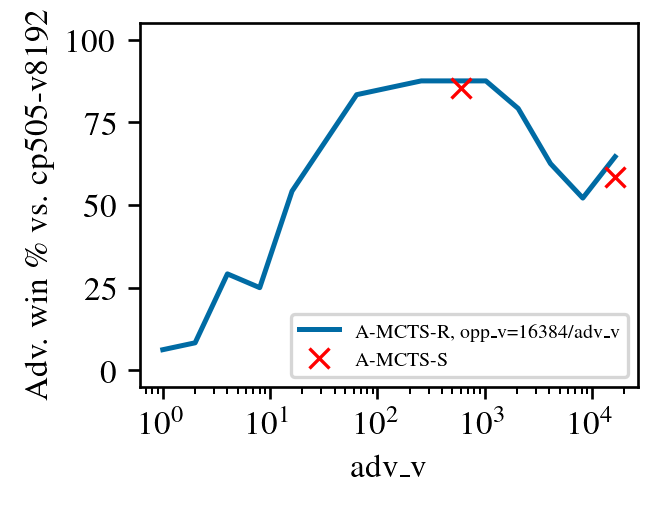

In [29]:
fig, ax = plt.subplots(1, 1)

win_rates = df_adv_n.groupby("adv_visits").adv_win.mean(numeric_only=True)
(100 * win_rates).plot(label="A-MCTS-R, opp_v=16384/adv_v")
plt.plot(600, 100 * adv_v600_win_rate, "rx", label="A-MCTS-S")
plt.plot(16384, 100 * adv_v16384_win_rate, "rx")

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel(f"Adv. win \\% vs. cp505-v8192")
plt.xlabel("adv_v")
plt.legend(prop={'size': 6})
force_minor_ticks(ax)

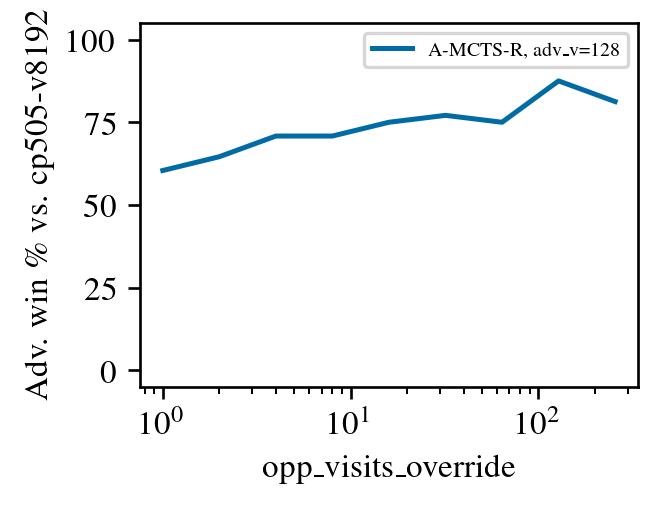

In [54]:
fig, ax = plt.subplots(1, 1)

win_rates = df_adv_128.groupby("opp_visits_override").adv_win.mean(numeric_only=True)
(100 * win_rates).plot(label="A-MCTS-R, adv_v=128")

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel(f"Adv. win \\% vs. cp505-v8192")
plt.xlabel("opp_visits_override")
plt.legend(prop={'size': 6})
# force_minor_ticks(ax)

In [50]:
df_adv_128.groupby("opp_visits_override").adv_win.mean(numeric_only=True)

opp_visits_override
1      0.604167
128    0.875000
16     0.750000
2      0.645833
256    0.812500
32     0.770833
4      0.708333
64     0.750000
8      0.708333
Name: adv_win, dtype: float64